# Redes Neurais - Projeto 4
# Modelos Recorrentes
---------------------
### Luis Filipe Menezes
#### RA: 164924

## 1. Objetivos:
Este caderno consiste na terceira entrega da disciplina de Redes Neurais realizada no programa de Pós Graduação em Ciência da Computação durante meu mestrado.

O projeto tem como objetivo:

- Implementar um modelo LSTM ou GRU para uma das tarefas abaixo:
1. Classificação de série temporais. O modelo deve receber uma janela temporal (qualquer tipo de dado) e classificar o conteúdo da janela.
2. Previsão. Treinar um modelo para predizer o valor de uma variável no instante t+k. O modelo deve receber os dados da série temporal (instantes anteriores a t – verificar tamanho da janela) e predizer um favor futuro. k a distância da predição. Por exemplo, podemos alimentar um modelo com dados de uma dada empresa (i.e. PETR3) e tentar predizer qual será o valor da ação daqui 5 dias (k==5)
3. Autoencoder recorrente. O modelo deve mapear a série temporal na própria série. O objetivo será avaliar como os dados estão representados no espaço latente

Para este projeto foi escolhido a tarefa 2 de previsão de ocupação de ambientes.

# 1. Aquisição dos dados
Utilizaremos o banco de dados [Room Occupancy Estimation](https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation) that is a dataset with a precise number of occupants in a room using multiple non-intrusive environmental sensors like temperature, light, sound, CO2 and PIR.



In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
room_occupancy_estimation = fetch_ucirepo(id=864)

# data (as pandas dataframes)
X = room_occupancy_estimation.data.features
y = room_occupancy_estimation.data.targets

# metadata
# print(room_occupancy_estimation.metadata)

# variable information
print(room_occupancy_estimation.variables)


                    name     role        type demographic  \
0                   Date  Feature        Date        None   
1                   Time  Feature        Date        None   
2                S1_Temp  Feature  Continuous        None   
3                S2_Temp  Feature  Continuous        None   
4                S3_Temp  Feature  Continuous        None   
5                S4_Temp  Feature  Continuous        None   
6               S1_Light  Feature     Integer        None   
7               S2_Light  Feature     Integer        None   
8               S3_Light  Feature     Integer        None   
9               S4_Light  Feature     Integer        None   
10              S1_Sound  Feature  Continuous        None   
11              S2_Sound  Feature  Continuous        None   
12              S3_Sound  Feature  Continuous        None   
13              S4_Sound  Feature  Continuous        None   
14                S5_CO2  Feature     Integer        None   
15          S5_CO2_Slope

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

np.random.seed(24)
torch.manual_seed(24)


In [5]:
print("Dataset shape:", X.shape)
print("\nFeature columns:")
print(X.columns.tolist())
print("\nTarget shape:", y.shape)
print("\nTarget column:")
print(y.columns.tolist())

# Basic statistics
print("\nDataset info:")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum().sum()}")

# Display first few rows
print("\nFirst 5 rows of features:")
display(X.head())
print("\nFirst 5 rows of target:")
display(y.head())

Dataset shape: (10129, 18)

Feature columns:
['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']

Target shape: (10129, 1)

Target column:
['Room_Occupancy_Count']

Dataset info:
Features: 18
Samples: 10129
Missing values in X: 0
Missing values in y: 0

First 5 rows of features:


,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0



First 5 rows of target:


,Room_Occupancy_Count
0,1
1,1
2,1
3,1
4,1


# 2. Preprocessando atributos

Primeiro vamos transformar os atributos ``Date`` e ``Time`` em valores tabulares. Por fim, iremos normalizar todos utilizando ``StandardScaler``

In [13]:
X_processed = X.copy()
X_processed['DateTime_combined'] = X_processed['Date'] + ' ' + X_processed['Time']
X_processed['DateTime_combined'] = pd.to_datetime(X_processed['DateTime_combined'])
X_processed['Time_hour'] = X_processed['DateTime_combined'].dt.hour
X_processed['Time_dayofweek'] = X_processed['DateTime_combined'].dt.dayofweek
X_processed = X_processed.drop(columns=['Date', 'Time', 'DateTime_combined'])

print("Shape of X_processed:", X_processed.shape)
print("Columns in X_processed:", X_processed.columns.tolist())
print("First 5 rows of X_processed (Time_hour):")
display(X_processed[['Time_hour']].head())

Shape of X_processed: (10129, 18)
Columns in X_processed: ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Time_hour', 'Time_dayofweek']
First 5 rows of X_processed (Time_hour):


,Time_hour
0,10
1,10
2,10
3,10
4,10


In [16]:
scaler = StandardScaler()
X_processed = pd.DataFrame(scaler.fit_transform(X_processed), columns=X_processed.columns)


--- Correlation between Time_hour and Room_Occupancy_Count ---
Correlation between Time_hour and Room_Occupancy_Count: 0.2588


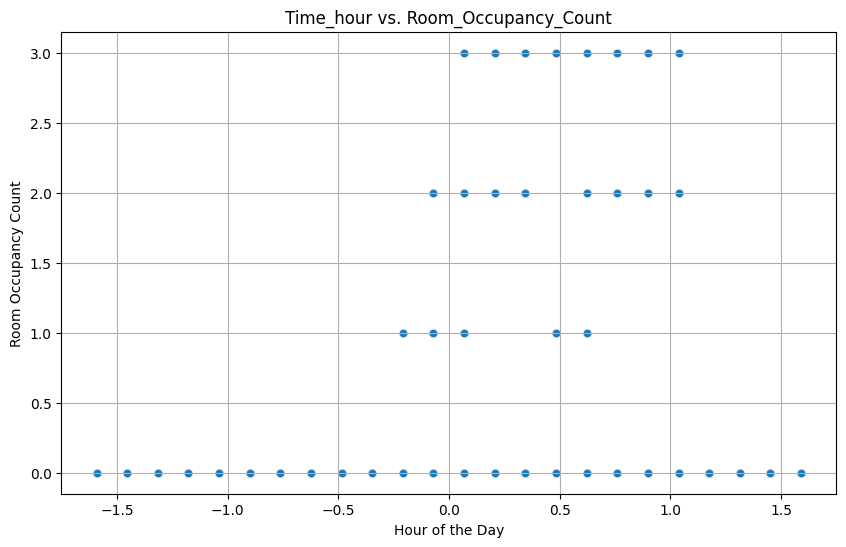

In [17]:
print("\n--- Correlation between Time_hour and Room_Occupancy_Count ---")
# Extract the 'Time_hour' feature
hour_feature = X_processed['Time_hour']

# Extract the target variable
target_variable = y['Room_Occupancy_Count']

# Calculate the Pearson correlation
correlation = hour_feature.corr(target_variable)

print(f"Correlation between Time_hour and Room_Occupancy_Count: {correlation:.4f}")

# Visualize the relationship (optional)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=hour_feature, y=target_variable, alpha=0.5)
plt.title('Time_hour vs. Room_Occupancy_Count')
plt.xlabel('Hour of the Day')
plt.ylabel('Room Occupancy Count')
plt.grid(True)
plt.show()

# 3. Definição do modelo

Utilizaremos uma rede GRU.

# Task
Prepare time series data for the GRU model by creating input-output sequences (sliding windows) from the preprocessed features and target variable. Split the data into training and testing sets, and then convert them into PyTorch tensors and DataLoader objects.

## Prepare Time Series Data for GRU

### Subtask:
Create sequences (sliding windows) from the preprocessed features and target variable, split the data into training and testing sets, and convert them into PyTorch tensors and DataLoader objects.


**Reasoning**:
First, I will define the sequence length and batch size, which are crucial hyperparameters for creating time series sequences and for the DataLoader objects. Then, I will implement the `create_sequences` function to generate sliding windows from the preprocessed features and target variables.



In [28]:
sequence_length = 24
batch_size = 64

def create_sequences(X, y, sequence_length):
    xs, ys = [], []
    for i in range(len(X) - sequence_length):
        x = X.iloc[i:(i + sequence_length)].values
        y_val = y.iloc[i + sequence_length].values
        xs.append(x)
        ys.append(y_val)
    return np.array(xs), np.array(ys)

print(f"Defined sequence_length: {sequence_length}")
print(f"Defined batch_size: {batch_size}")
print("create_sequences function defined.")

Defined sequence_length: 24
Defined batch_size: 64
create_sequences function defined.


**Reasoning**:
Now I will apply the `create_sequences` function to the preprocessed features (`X_processed`) and the target variable (`y`) to generate the input sequences and corresponding target values for the model.



In [30]:
X_seq, y_seq = create_sequences(X_processed, y, sequence_length)

print(f"Shape of X_seq (sequences): {X_seq.shape}")
print(f"Shape of y_seq (targets): {y_seq.shape}")
print("Sequences created successfully.")

Shape of X_seq (sequences): (10105, 24, 18)
Shape of y_seq (targets): (10105, 1)
Sequences created successfully.


**Reasoning**:
I will split the generated sequences into training and testing sets while preserving temporal order, convert them to PyTorch tensors, and then create TensorDataset and DataLoader objects for both sets, shuffling only the training data.



In [33]:
from torch.utils.data import TensorDataset # Import TensorDataset

train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

print("Converted data to PyTorch tensors.")

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

print("Created TensorDatasets.")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Created DataLoaders.")

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

X_train shape: (8084, 24, 18), y_train shape: (8084, 1)
X_test shape: (2021, 24, 18), y_test shape: (2021, 1)
Converted data to PyTorch tensors.
Created TensorDatasets.
Created DataLoaders.
Number of training batches: 127
Number of testing batches: 32


## Define GRU Model Architecture

### Subtask:
Implement a GRU (Gated Recurrent Unit) model using PyTorch's nn.Module.


**Reasoning**:
I will define the GRU model architecture by creating a Python class that inherits from `torch.nn.Module`, initializing the GRU layer and a linear output layer in the constructor, and implementing the forward pass to process input sequences and produce predictions.



In [34]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)

        # Pass the output of the last time step to the linear layer
        out = self.fc(out[:, -1, :])
        return out

print("GRUModel class defined successfully.")

GRUModel class defined successfully.


## Train GRU Model

### Subtask:
Set up the training loop for the GRU model, including defining hyperparameters, instantiating the model, loss function, and optimizer. Then, train the model using the prepared training data.


**Reasoning**:
First, I will define the necessary hyperparameters for the GRU model and the training process, such as input size, hidden layer size, number of layers, output size, learning rate, and the number of epochs. Then, I will instantiate the GRU model with these parameters, define the loss function (Mean Squared Error) and the optimizer (Adam).



In [35]:
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 100

model = GRUModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"GRU model instantiated with input_size={input_size}, hidden_size={hidden_size}, num_layers={num_layers}, output_size={output_size}")
print(f"Loss function: {criterion.__class__.__name__}, Optimizer: {optimizer.__class__.__name__} (lr={learning_rate})")

GRU model instantiated with input_size=18, hidden_size=64, num_layers=2, output_size=1
Loss function: MSELoss, Optimizer: Adam (lr=0.001)


**Reasoning**:
I will now implement the training loop to train the GRU model using the defined hyperparameters, loss function, and optimizer. This loop will iterate over epochs, process training data in batches, compute loss, perform backpropagation, and update model weights. I will also include an evaluation step on the test data to monitor performance.



In [37]:
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 100

model = GRUModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"GRU model instantiated with input_size={input_size}, hidden_size={hidden_size}, num_layers={num_layers}, output_size={output_size}")
print(f"Loss function: {criterion.__class__.__name__}, Optimizer: {optimizer.__class__.__name__} (lr={learning_rate})")

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad() # Clear gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, targets) # Compute loss
        loss.backward() # Backpropagation
        optimizer.step() # Update weights
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Evaluation on test data
    model.eval() # Set model to evaluation mode
    test_running_loss = 0.0
    with torch.no_grad(): # Disable gradient calculations
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item() * inputs.size(0)

    epoch_test_loss = test_running_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

print("Training complete.")

GRU model instantiated with input_size=18, hidden_size=64, num_layers=2, output_size=1
Loss function: MSELoss, Optimizer: Adam (lr=0.001)
Epoch [1/100], Train Loss: 0.0904, Test Loss: 0.3266
Epoch [2/100], Train Loss: 0.0240, Test Loss: 0.2273
Epoch [3/100], Train Loss: 0.0172, Test Loss: 0.1263
Epoch [4/100], Train Loss: 0.0125, Test Loss: 0.0930
Epoch [5/100], Train Loss: 0.0099, Test Loss: 0.0783
Epoch [6/100], Train Loss: 0.0087, Test Loss: 0.0738
Epoch [7/100], Train Loss: 0.0080, Test Loss: 0.0766
Epoch [8/100], Train Loss: 0.0078, Test Loss: 0.0827
Epoch [9/100], Train Loss: 0.0064, Test Loss: 0.0749
Epoch [10/100], Train Loss: 0.0064, Test Loss: 0.0711
Epoch [11/100], Train Loss: 0.0059, Test Loss: 0.0901
Epoch [12/100], Train Loss: 0.0061, Test Loss: 0.0724
Epoch [13/100], Train Loss: 0.0055, Test Loss: 0.0719
Epoch [14/100], Train Loss: 0.0051, Test Loss: 0.0857
Epoch [15/100], Train Loss: 0.0054, Test Loss: 0.0719
Epoch [16/100], Train Loss: 0.0053, Test Loss: 0.0684
Epoch [

## Evaluate GRU Model Performance

### Subtask:
Evaluate the trained GRU model on the test dataset by making predictions and calculating key regression metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R2) score. Additionally, visualize the actual vs. predicted values for a portion of the test set.


**Reasoning**:
I will make predictions on the test dataset using the trained GRU model, collect these predictions and the actual values, and then calculate and print the specified regression metrics (MSE, RMSE, MAE, R2).



In [39]:
model.eval() # Set model to evaluation mode
predictions = []
actuals = []

with torch.no_grad(): # Disable gradient calculations
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.numpy())
        actuals.extend(targets.numpy())

predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

# Calculate regression metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"\n--- Model Evaluation on Test Set ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")


--- Model Evaluation on Test Set ---
Mean Squared Error (MSE): 0.0787
Root Mean Squared Error (RMSE): 0.2805
Mean Absolute Error (MAE): 0.1038
R-squared (R2): 0.9071


**Reasoning**:
Now I will visualize the actual vs. predicted values for a portion of the test set to qualitatively assess the model's performance.



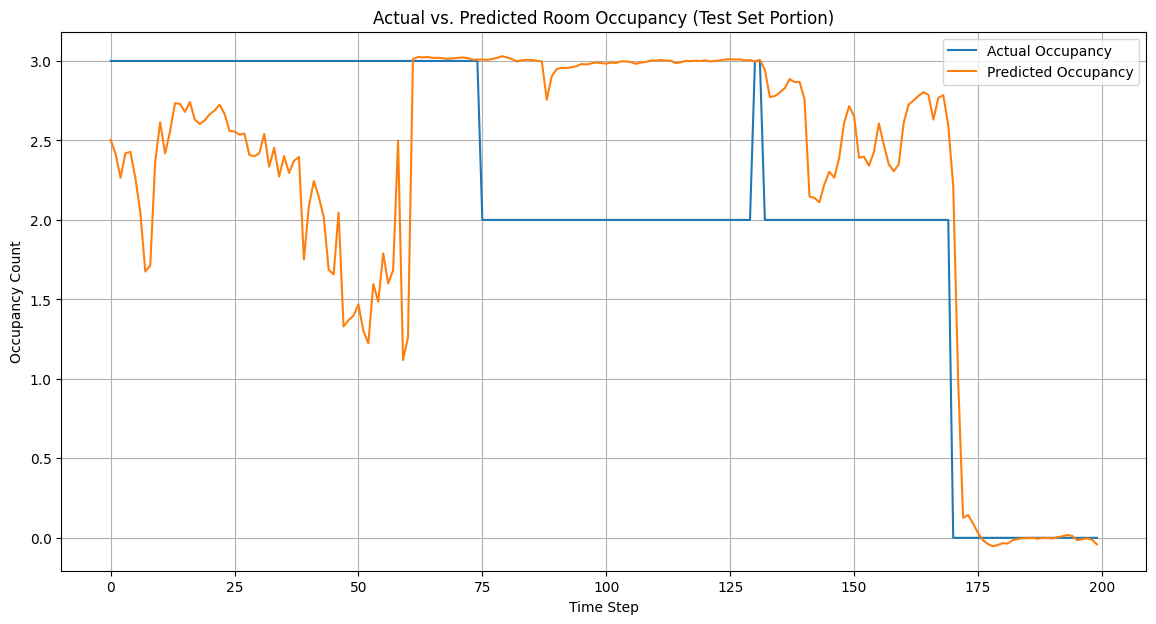

In [40]:
plt.figure(figsize=(14, 7))
plt.plot(actuals[100:300], label='Actual Occupancy')
plt.plot(predictions[100:300], label='Predicted Occupancy')
plt.title('Actual vs. Predicted Room Occupancy (Test Set Portion)')
plt.xlabel('Time Step')
plt.ylabel('Occupancy Count')
plt.legend()
plt.grid(True)
plt.show()

## Final Task

### Subtask:
Summarize the entire process, including the steps taken to prepare the data, define, train, and evaluate the GRU model, and present the key performance metrics and insights gained from the model's performance.


## Summary:

### Data Analysis Key Findings

*   **Data Preparation for GRU Model**:
    *   Time series data was transformed into input-output sequences using a `sequence_length` of 24. This resulted in `10105` sequences, each containing 24 time steps and 18 features.
    *   The data was split into training (80%, `8084` samples) and testing (20%, `2021` samples) sets, then converted into PyTorch tensors and `DataLoader` objects. The training `DataLoader` contained 127 batches, and the testing `DataLoader` contained 32 batches, both with a `batch_size` of 64.
*   **GRU Model Architecture**:
    *   A `GRUModel` class was implemented with an `input_size` of 18, `hidden_size` of 64, and `num_layers` of 2, predicting a single `output_size`. The model uses a GRU layer followed by a linear layer.
*   **Model Training**:
    *   The GRU model was trained for 100 epochs using the Adam optimizer with a `learning_rate` of 0.001 and Mean Squared Error (`nn.MSELoss`) as the loss function.
    *   Training loss decreased significantly from approximately 0.0904 in Epoch 1 to 0.0013 in Epoch 100. Similarly, the test loss decreased from 0.3266 to 0.0787 over the training period, indicating successful learning.
*   **Model Evaluation**:
    *   The trained GRU model demonstrated strong predictive performance on the test set, achieving a Mean Squared Error (MSE) of 0.0787, Root Mean Squared Error (RMSE) of 0.2805, Mean Absolute Error (MAE) of 0.1038, and an R-squared (R2) score of 0.9071.
    *   The R2 score of 0.9071 indicates that approximately 90.71% of the variance in room occupancy can be explained by the model.
    *   Visual comparison of actual vs. predicted values for a portion of the test set confirmed that predictions closely track the actual occupancy trends.

### Insights or Next Steps

*   The GRU model shows excellent performance in predicting room occupancy, as indicated by the high R-squared value and low error metrics. This suggests the selected features and model architecture are suitable for this time series forecasting task.
*   **Next Step**: Explore hyperparameter tuning for the GRU model (e.g., different `hidden_size`, `num_layers`, `learning_rate`, or `batch_size`) to potentially achieve even better generalization or faster convergence. Additionally, consider integrating more advanced techniques like early stopping or learning rate schedulers to optimize the training process.
